In [1]:
import plotly.offline as pyo

In [2]:
pyo.init_notebook_mode()

In [3]:
import numpy as np

In [4]:
import pandas as pd

In [5]:
import matplotlib.pyplot as plt

In [6]:
import os

In [7]:
import cv2 

In [8]:
from plotly.subplots import make_subplots

In [9]:
import plotly.graph_objects as go

In [10]:
from sklearn import preprocessing

In [11]:
import random

In [12]:
import tensorflow as tf

In [13]:
import warnings
warnings.filterwarnings("ignore")

In [14]:
from tqdm import tqdm

In [15]:
from sklearn.preprocessing import OneHotEncoder

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
import visualkeras

In [18]:
from tensorflow.keras.models import Model

In [19]:
from matplotlib.pyplot import figure

In [20]:
from numpy import expand_dims

In [21]:
import plotly.express as px

In [22]:
import plotly.io as pio

In [23]:
import statsmodels.api as sm

In [24]:
from tensorflow.keras.utils import plot_model

In [25]:
from matplotlib import pyplot
from matplotlib.pyplot import figure

In [26]:
import io

In [27]:
def Create_Directory_DataFrame():
    df =pd.DataFrame(columns=['Class','Location'])
    basedir = 'Soil_Dataset/'
    for folder in os.listdir(basedir):
        for Class in os.listdir(basedir+folder+'/'):
            for location in os.listdir(basedir+folder+'/'+Class+'/'):
                df = df.append({'Class':Class,'Location':basedir+folder+'/'+Class+'/'+location},ignore_index=True)
    df = df.sample(frac = 1) 
    return df

In [28]:
df = Create_Directory_DataFrame()
print(df.shape)
df.head()

(903, 2)


Class                                         Location
527     Black_Soil       Soil_Dataset/Train/Black_Soil/Black_56.jpg
179       Red_Soil            Soil_Dataset/Test/Red_Soil/Red_43.jpg
43   Alluvial_Soil   Soil_Dataset/Test/Alluvial_Soil/Alluvial_5.jpg
19   Alluvial_Soil  Soil_Dataset/Test/Alluvial_Soil/Alluvial_27.jpg
898       Red_Soil           Soil_Dataset/Train/Red_Soil/Red_95.jpg

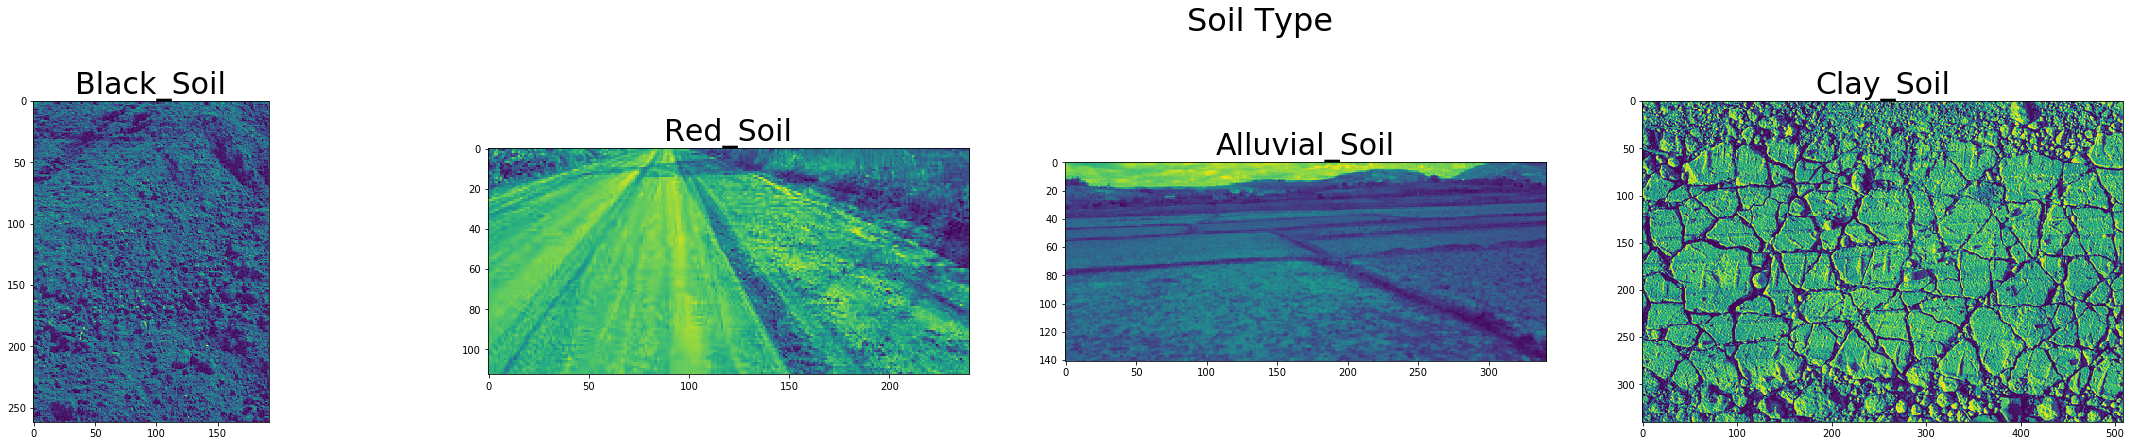

In [29]:
count = 1
f = plt.figure(figsize=(50,13))
for Class in df['Class'].unique():
    seg = df[df['Class']==Class]
    address =  seg.sample().iloc[0]['Location']
    img = cv2.imread(address,0)
    ax = f.add_subplot(2, 5,count)
    ax = plt.imshow(img)
    ax = plt.title(Class,fontsize= 30)
    count = count + 1
plt.suptitle("Soil Type", size = 32)
plt.show()

In [30]:
img.shape

(340, 509)

In [31]:
w , h= 64,64
final_class = 4
train_image = []

In [32]:
for location in tqdm(df.iloc[:]['Location']):
    img = cv2.imread(location,0)
    img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
    img = img.reshape(w,h,1)
    train_image.append(img)

100%|███████████████████████████████████████████████████████████████████████████████| 903/903 [00:03<00:00, 235.23it/s]


In [33]:
X = np.array(train_image)

In [34]:
y = np.array(df.iloc[:]['Class'])

In [35]:
y = y.reshape(y.shape[0],1)

In [36]:
enc = OneHotEncoder(handle_unknown='ignore')

In [37]:
enc.fit(y)

OneHotEncoder(categories='auto', drop=None, dtype=<class 'numpy.float64'>,
              handle_unknown='ignore', sparse=True)

In [38]:
print(enc.categories_)

[array(['Alluvial_Soil', 'Black_Soil', 'Clay_Soil', 'Red_Soil'],
      dtype=object)]


In [39]:
y = enc.transform(y).toarray()

In [40]:
print(X[0].reshape(w,h))

[[41 45 49 ... 39 30 25]
 [41 34 41 ... 41 42 41]
 [43 47 38 ... 33 32 30]
 ...
 [ 5  6  8 ...  7  4  3]
 [ 8 10 11 ...  5  4  3]
 [ 4  5  7 ...  5  5  4]]


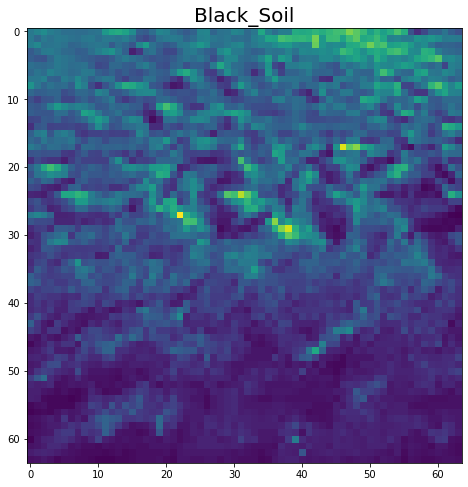

In [41]:
plt.figure(figsize=(25,8))
plt.imshow(X[0].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,final_class))[0][0],size = 20)
plt.show()

In [42]:
y[0]


array([0., 1., 0., 0.])

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.1)

In [44]:
print('Train data    :'+str(X_train.shape))
print('Test data     :'+str(X_test.shape))
print('Train Output  :'+str(y_train.shape))
print('Test Output   :'+str(y_test.shape))

Train data    :(812, 64, 64, 1)
Test data     :(91, 64, 64, 1)
Train Output  :(812, 4)
Test Output   :(91, 4)


In [45]:
def conv_block(filters):
    block = tf.keras.Sequential([
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.SeparableConv2D(filters, 3, activation='relu', padding='same'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.MaxPool2D()
    ]
    )
    return block

In [46]:
def dense_block(units, dropout_rate):
    block = tf.keras.Sequential([
        tf.keras.layers.Dense(units, activation='relu'),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(dropout_rate)
    ])
    return block

In [47]:
def build_model(act , final_class , w , h ):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(w , h , 1)),
        
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.Conv2D(16, 3, activation=act, padding='same'),
        tf.keras.layers.MaxPool2D(),
        
        conv_block(32),
        conv_block(64),
        
        conv_block(128),
        tf.keras.layers.Dropout(0.2),
        
        conv_block(256),
        tf.keras.layers.Dropout(0.2),
        
        tf.keras.layers.Flatten(),
        dense_block(512, 0.7),
        dense_block(128, 0.5),
        dense_block(64, 0.3),
        
        tf.keras.layers.Dense(final_class, activation='sigmoid')
    ])
    return model

In [48]:
def wrap(Training_Output_Results , Opt , Act ,  history):
    epoch  = len(history.history['loss'])
    epochs = list(np.arange(1,epoch + 1,1))
    Optimizer = np.repeat(Opt,epoch).tolist()
    Activation = np.repeat(Act,epoch).tolist()
    cumiliated_res = {}
    cumiliated_res['Epochs']=epochs
    cumiliated_res['Optimizer']=Optimizer
    cumiliated_res['Activation_Function']=Activation
    cumiliated_res['Train_Loss']=history.history['loss']
    cumiliated_res['Train_Accuracy']=history.history['accuracy']
    cumiliated_res['Train_Precision']=history.history['precision']
    cumiliated_res['Train_Recall']=history.history['recall']
    cumiliated_res['Val_Loss']=history.history['val_loss']
    cumiliated_res['Val_Accuracy']=history.history['val_accuracy']
    cumiliated_res['Val_Precision']=history.history['val_precision']
    cumiliated_res['Val_Recall']=history.history['val_recall']
    convertDictionary = pd.DataFrame(cumiliated_res)
    Training_Output_Results = Training_Output_Results.append(convertDictionary)
    return Training_Output_Results

In [49]:
Optimisers = ['RMSprop','Adam','Adadelta','Adagrad']

In [50]:
Activation_function =['relu','sigmoid','softmax','tanh','softsign','selu','elu']

In [51]:
Training_Output_Results =pd.DataFrame(columns=['Epochs','Optimizer','Activation_Function','Train_Loss','Train_Accuracy','Train_Precision','Train_Recall', 'Val_Loss','Val_Accuracy','Val_Precision','Val_Recall'])


In [52]:
def Optimise_verify(Training_Output_Results):
    for opt in Optimisers:
        model = build_model(Activation_function[0], final_class , w , h)
        METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
        ]  
        model.compile(
                optimizer=opt,
                loss='categorical_crossentropy',
                metrics=METRICS
            )
        history = model.fit(X_train, y_train, epochs=100, validation_split=0.3, batch_size=15,verbose=0,shuffle=True)
        Training_Output_Results = wrap(Training_Output_Results , opt,Activation_function[0],history)
        print('---------------------Round for '+opt+' Completed-----------------------------------------')
    return Training_Output_Results
    
    
Training_Output_Results = Optimise_verify(Training_Output_Results)

---------------------Round for RMSprop Completed-----------------------------------------
---------------------Round for Adam Completed-----------------------------------------
---------------------Round for Adadelta Completed-----------------------------------------
---------------------Round for Adagrad Completed-----------------------------------------


In [53]:
Training_Output_Results=Training_Output_Results.sample(frac = 1) 
print(Training_Output_Results.shape)

(400, 11)


In [54]:
Training_Output_Results.to_csv('Optimizer_64_64_data.csv', index = False) 

In [55]:
Training_Output_Results.head()

Epochs Optimizer Activation_Function  Train_Loss  Train_Accuracy  \
82     83      Adam                relu    0.151417        0.959507   
2       3   RMSprop                relu    0.903335        0.633803   
88     89   Adagrad                relu    0.852392        0.654930   
79     80  Adadelta                relu    1.483048        0.297535   
34     35  Adadelta                relu    1.558976        0.271127   

    Train_Precision  Train_Recall  Val_Loss  Val_Accuracy  Val_Precision  \
82         0.961749      0.929577  0.587270      0.815574       0.827869   
2          0.463504      0.894366  1.460051      0.241803       0.231557   
88         0.489914      0.897887  0.671863      0.766393       0.559902   
79         0.271020      0.533451  1.296783      0.467213       0.372960   
34         0.264202      0.515845  1.364856      0.397541       0.296912   

    Val_Recall  
82    0.827869  
2     0.463115  
88    0.938525  
79    0.655738  
34    0.512295

In [56]:
Training_Output_Results =pd.DataFrame(columns=['Epochs','Optimizer','Activation_Function','Train_Loss','Train_Accuracy','Train_Precision','Train_Recall',
                                              'Val_Loss','Val_Accuracy','Val_Precision','Val_Recall'])

In [57]:
def Activation_verify(Training_Output_Results):
    for act in Activation_function:
        model = build_model(act,final_class,w,h)
        METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
        ]  
        model.compile(
                optimizer=Optimisers[0],
                loss='categorical_crossentropy',
                metrics=METRICS
            )
        history = model.fit(X_train, y_train, epochs=100, validation_split=0.3, batch_size=15,verbose=0,shuffle=True)
        Training_Output_Results = wrap(Training_Output_Results , Optimisers[0],act,history)
        print('---------------------Round for '+act+' Completed-----------------------------------------')
    return Training_Output_Results

In [58]:
Training_Output_Results = Activation_verify(Training_Output_Results)

---------------------Round for relu Completed-----------------------------------------
---------------------Round for sigmoid Completed-----------------------------------------
---------------------Round for softmax Completed-----------------------------------------
---------------------Round for tanh Completed-----------------------------------------
---------------------Round for softsign Completed-----------------------------------------
---------------------Round for selu Completed-----------------------------------------
---------------------Round for elu Completed-----------------------------------------


In [59]:
Training_Output_Results=Training_Output_Results.sample(frac = 1) 
print(Training_Output_Results.shape)

(700, 11)


In [60]:
Training_Output_Results.to_csv('Activation_64_64_data.csv', index = False)
Training_Output_Results.head()

Epochs Optimizer Activation_Function  Train_Loss  Train_Accuracy  \
6       7   RMSprop                selu    0.792356        0.709507   
71     72   RMSprop             sigmoid    0.243443        0.926056   
53     54   RMSprop             sigmoid    0.381435        0.875000   
10     11   RMSprop                tanh    0.860084        0.626761   
95     96   RMSprop                tanh    0.229744        0.927817   

    Train_Precision  Train_Recall  Val_Loss  Val_Accuracy  Val_Precision  \
6          0.519388      0.896127  1.667040      0.241803       0.231557   
71         0.892206      0.947183  3.744685      0.336066       0.330159   
53         0.796662      0.924296  5.797800      0.397541       0.396610   
10         0.488038      0.897887  1.913103      0.241803       0.255464   
95         0.912671      0.938380  3.766193      0.327869       0.316364   

    Val_Recall  
6     0.463115  
71    0.426230  
53    0.479508  
10    0.766393  
95    0.356557

In [61]:
opt = pd.read_csv('./Optimizer_64_64_data.csv')
act = pd.read_csv('./Activation_64_64_data.csv')

In [62]:

scatterplot = px.scatter(
    data_frame=opt,
    x="Epochs",
    y="Train_Accuracy",
    color="Optimizer",                                              
    color_discrete_sequence=["red","orange","blue","black"],   
    
    title='Train Accuracy',         
    template='presentation',     
)
pyo.iplot(scatterplot, filename = 'Opt_train_acc')

In [63]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Train_Loss",
    color="Optimizer",                                              
    color_discrete_sequence=["red","orange","blue","green"],  
    
    title='Train Loss',          
    template='presentation')     
pyo.iplot(scatterplot, filename = 'Opt_train_loss')

In [64]:
scatterplot = px.scatter(
    data_frame=opt,
    x="Epochs",
    y="Train_Precision",
    size='Train_Precision',
    color="Optimizer",                                              
    color_discrete_sequence=["red","orange","blue","green"],   
   
    facet_col='Optimizer',       
    facet_col_wrap=2,           
    
    title='Train Precision',          
    template='presentation',     
)
pyo.iplot(scatterplot, filename = 'Opt_train_prec')

In [65]:
scatterplot = px.scatter(
    data_frame=opt,
    x="Epochs",
    y="Train_Recall",
    size ='Train_Recall',
    color="Optimizer",                                              # set opacity of markers
    color_discrete_sequence=["red","orange","blue","green"],   # set marker colors. When color colum isn't numeric data
   
    facet_col='Optimizer',       
    facet_col_wrap=2,           
    
    
    
    title='Train Recall',           
    
    template='presentation',     
                                
)

pyo.iplot(scatterplot, filename = 'Opt_train_recall')

In [66]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Val_Accuracy",
    color="Optimizer",                                              
    color_discrete_sequence=["red","orange","blue","green"],   
   
    facet_col='Optimizer',       
    facet_col_wrap=2,           
    
    title='Validation Accuracy',           
    
    template='presentation',     
                                
)
pyo.iplot(scatterplot, filename = 'Opt_val_acc')

In [67]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Val_Precision",
    color="Optimizer",                                              
    color_discrete_sequence=["red","orange","blue","green"],   
   
    facet_col='Optimizer',       
    facet_col_wrap=2,           
    
    title='Validation Precision',           
    
    template='presentation',     
                        
)
pyo.iplot(scatterplot, filename = 'Opt_val_prec')

In [68]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Val_Recall",
    color="Optimizer",                                              
    color_discrete_sequence=["red","orange","blue","green"],   
   
    facet_col='Optimizer',       
    facet_col_wrap=2,           
    
    title='Validation Recall',           
    template='presentation',     
                                
                                
)

pyo.iplot(scatterplot, filename = 'Opt_val_recall')


In [69]:
scatterplot = px.area(
    data_frame=opt,
    x="Epochs",
    y="Val_Loss",
    color="Optimizer",                                              
    color_discrete_sequence=["red","orange","blue","green"],   
   
    facet_col='Optimizer',       
    facet_col_wrap=2,           
    
        
    title='Validation Loss',           
    
    template='presentation',     
                                
)

pyo.iplot(scatterplot, filename = 'Opt_val_loss')

In [70]:

scatterplot = px.scatter(
    data_frame=act,
    x="Epochs",
    y="Train_Accuracy",
    size="Train_Accuracy",
    color="Activation_Function",                                              
    color_discrete_sequence=["red","orange","blue","green"],   
    
    title='Train Accuracy',           
    
    template='presentation',     
                                
                               
)
pyo.iplot(scatterplot, filename = 'Act_train_acc')


In [71]:
scatterplot = px.area(
    data_frame=act,
    x="Epochs",
    y="Train_Loss",
    color="Activation_Function",                                              
    color_discrete_sequence=["red","orange","blue","green"],   
    
    title='Train Loss',           
    
    template='presentation',     
                               
)
pyo.iplot(scatterplot, filename = 'Act_train_loss')

In [72]:

scatterplot = px.scatter(
    data_frame=act,
    x="Epochs",
    y="Train_Precision",
    size = "Train_Precision",
    color="Activation_Function",                                              
    color_discrete_sequence=["red","orange","blue","green"],   
   
    
    
    title='Train Precision',           
    template='presentation',    
                               
)
pyo.iplot(scatterplot, filename = 'Act_train_prec')

In [73]:
scatterplot = px.scatter(
    data_frame=act,
    x="Epochs",
    y="Train_Recall",
    size = "Train_Recall",
    color="Activation_Function",                                              
    color_discrete_sequence=["red","orange","blue","green"],   
   
    
    
    title='Train Precision',           
    
    template='presentation',     
                                
)

pyo.iplot(scatterplot, filename = 'Act_train_prec')

In [74]:
tab_opt = opt[opt['Epochs']==100]
final_col = np.delete(tab_opt.columns[0:], [0,2])
fig = go.Figure(data=[go.Table(
    header=dict(values=list(final_col),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[tab_opt.Optimizer , tab_opt.Train_Loss,tab_opt.Train_Accuracy,tab_opt.Train_Precision,tab_opt.Train_Recall,tab_opt.Val_Loss,tab_opt.Val_Accuracy,tab_opt.Val_Precision,tab_opt.Val_Recall],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [75]:
ty =opt[opt['Epochs']==100].iloc[:,3:]
nm = ty.columns
ty = ty.values.tolist()
data = []

for j in range(len(nm)):
        lt = []
        for i in range(len(Optimisers)):
            lt.append(ty[i][j])
            
        data.append(go.Bar(name = nm[j],x=Optimisers, y=lt))
fig = go.Figure(data=data)
fig.update_layout(barmode='group', title_text="Training Loss/Accuracy/Precsion/Recall vs Validation Loss/Accuracy/Precsion/Recall - Epoch == 100")
fig.show()

In [76]:
tab_opt = act[act['Epochs']==100]
final_col = np.delete(tab_opt.columns[0:], [0,1])
fig = go.Figure(data=[go.Table(
    header=dict(values=list(final_col),
                fill_color='paleturquoise',
                align='left'),
    cells=dict(values=[tab_opt.Activation_Function , tab_opt.Train_Loss,tab_opt.Train_Accuracy,tab_opt.Train_Precision,tab_opt.Train_Recall,tab_opt.Val_Loss,tab_opt.Val_Accuracy,tab_opt.Val_Precision,tab_opt.Val_Recall],
               fill_color='lavender',
               align='left'))
])

fig.show()

In [77]:
ty =act[act['Epochs']==10].iloc[:,3:]
nm = ty.columns
ty = ty.values.tolist()
data = []

for j in range(len(nm)):
        lt = []
        for i in range(len(Activation_function)):
            lt.append(ty[i][j])
            
        data.append(go.Bar(name = nm[j],x=Activation_function, y=lt))
fig = go.Figure(data=data)
fig.update_layout(barmode='group', title_text="Training Loss/Accuracy/Precsion/Recall vs Validation Loss/Accuracy/Precsion/Recall - Epoch == 10")
fig.show()


In [78]:
def Plot(history , name , model):
    model.save(name+'.h5')
    epochs = range(1,len(history.history['loss']) + 1)
    epochs = list(epochs)
    fig = make_subplots(rows=2, cols=4,subplot_titles=("Train Loss", "Train Accuracy" , "Train Precision","Train Recall", "Validation Loss", "Validation Accuracy",
                                                      "Validation Precision","Validation Recall"))
    fig.add_trace(go.Scatter(x=epochs, y=history.history['loss']), row=1, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['accuracy']), row=1, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['precision']), row=1, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['recall']), row=1, col=4)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_loss']), row=2, col=1)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_accuracy']), row=2, col=2)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_precision']), row=2, col=3)
    fig.add_trace(go.Scatter(x=epochs, y=history.history['val_recall']), row=2, col=4)
    fig.update_layout(showlegend=False,height=1000, width=1200, title_text=name)
    pyo.iplot(fig, filename = 'Act_train_rec')

In [79]:
model = build_model('relu', final_class ,w , h)
METRICS = [
                'accuracy',
                tf.keras.metrics.Precision(name='precision'),
                tf.keras.metrics.Recall(name='recall')
]  
model.compile(
                optimizer='RMSprop',
                loss='categorical_crossentropy',
                metrics=METRICS
        )
history = model.fit(X_train, y_train, epochs=100, validation_split=0.3, batch_size=15,verbose=1,shuffle=True)

Epoch 1/100
38/38 [==============================] - 4s 104ms/step - loss: 1.2916 - accuracy: 0.4049 - precision: 0.3353 - recall: 0.6901 - val_loss: 1.3828 - val_accuracy: 0.3033 - val_precision: 0.2500 - val_recall: 1.0000
Epoch 2/100
38/38 [==============================] - 3s 89ms/step - loss: 1.0821 - accuracy: 0.5475 - precision: 0.3946 - recall: 0.8275 - val_loss: 1.3881 - val_accuracy: 0.2418 - val_precision: 0.2555 - val_recall: 0.7664
Epoch 3/100
38/38 [==============================] - 4s 105ms/step - loss: 0.9766 - accuracy: 0.5757 - precision: 0.4335 - recall: 0.8785 - val_loss: 1.4174 - val_accuracy: 0.2418 - val_precision: 0.2555 - val_recall: 0.7664
Epoch 4/100
38/38 [==============================] - 4s 106ms/step - loss: 0.8957 - accuracy: 0.6373 - precision: 0.4684 - recall: 0.9137 - val_loss: 1.4784 - val_accuracy: 0.2418 - val_precision: 0.2316 - val_recall: 0.4631
Epoch 5/100
38/38 [==============================] - 3s 88ms/step - loss: 0.8958 - accuracy: 0.6690 -

38/38 [==============================] - 4s 93ms/step - loss: 0.2040 - accuracy: 0.9507 - precision: 0.9469 - recall: 0.9419 - val_loss: 1.0036 - val_accuracy: 0.7746 - val_precision: 0.7635 - val_recall: 0.7541
Epoch 74/100
38/38 [==============================] - 4s 100ms/step - loss: 0.1369 - accuracy: 0.9525 - precision: 0.9426 - recall: 0.9542 - val_loss: 0.6974 - val_accuracy: 0.8279 - val_precision: 0.8272 - val_recall: 0.8238
Epoch 75/100
38/38 [==============================] - 4s 98ms/step - loss: 0.2330 - accuracy: 0.9401 - precision: 0.9267 - recall: 0.9349 - val_loss: 0.6297 - val_accuracy: 0.8484 - val_precision: 0.8512 - val_recall: 0.8443
Epoch 76/100
38/38 [==============================] - 4s 99ms/step - loss: 0.2406 - accuracy: 0.9349 - precision: 0.9347 - recall: 0.9331 - val_loss: 0.5889 - val_accuracy: 0.8402 - val_precision: 0.8619 - val_recall: 0.8443
Epoch 77/100
38/38 [==============================] - 4s 100ms/step - loss: 0.1175 - accuracy: 0.9718 - precisio

In [80]:
Plot(history , 'final_model',model)

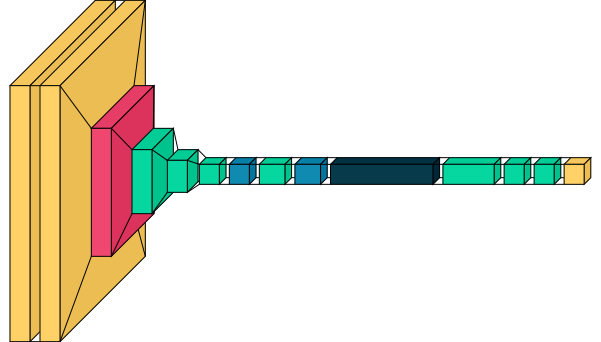

In [81]:
visualkeras.layered_view(model)

In [82]:
plot_model(model, to_file='model.png',show_shapes=True)

Failed to import pydot. You must install pydot and graphviz for `pydotprint` to work.


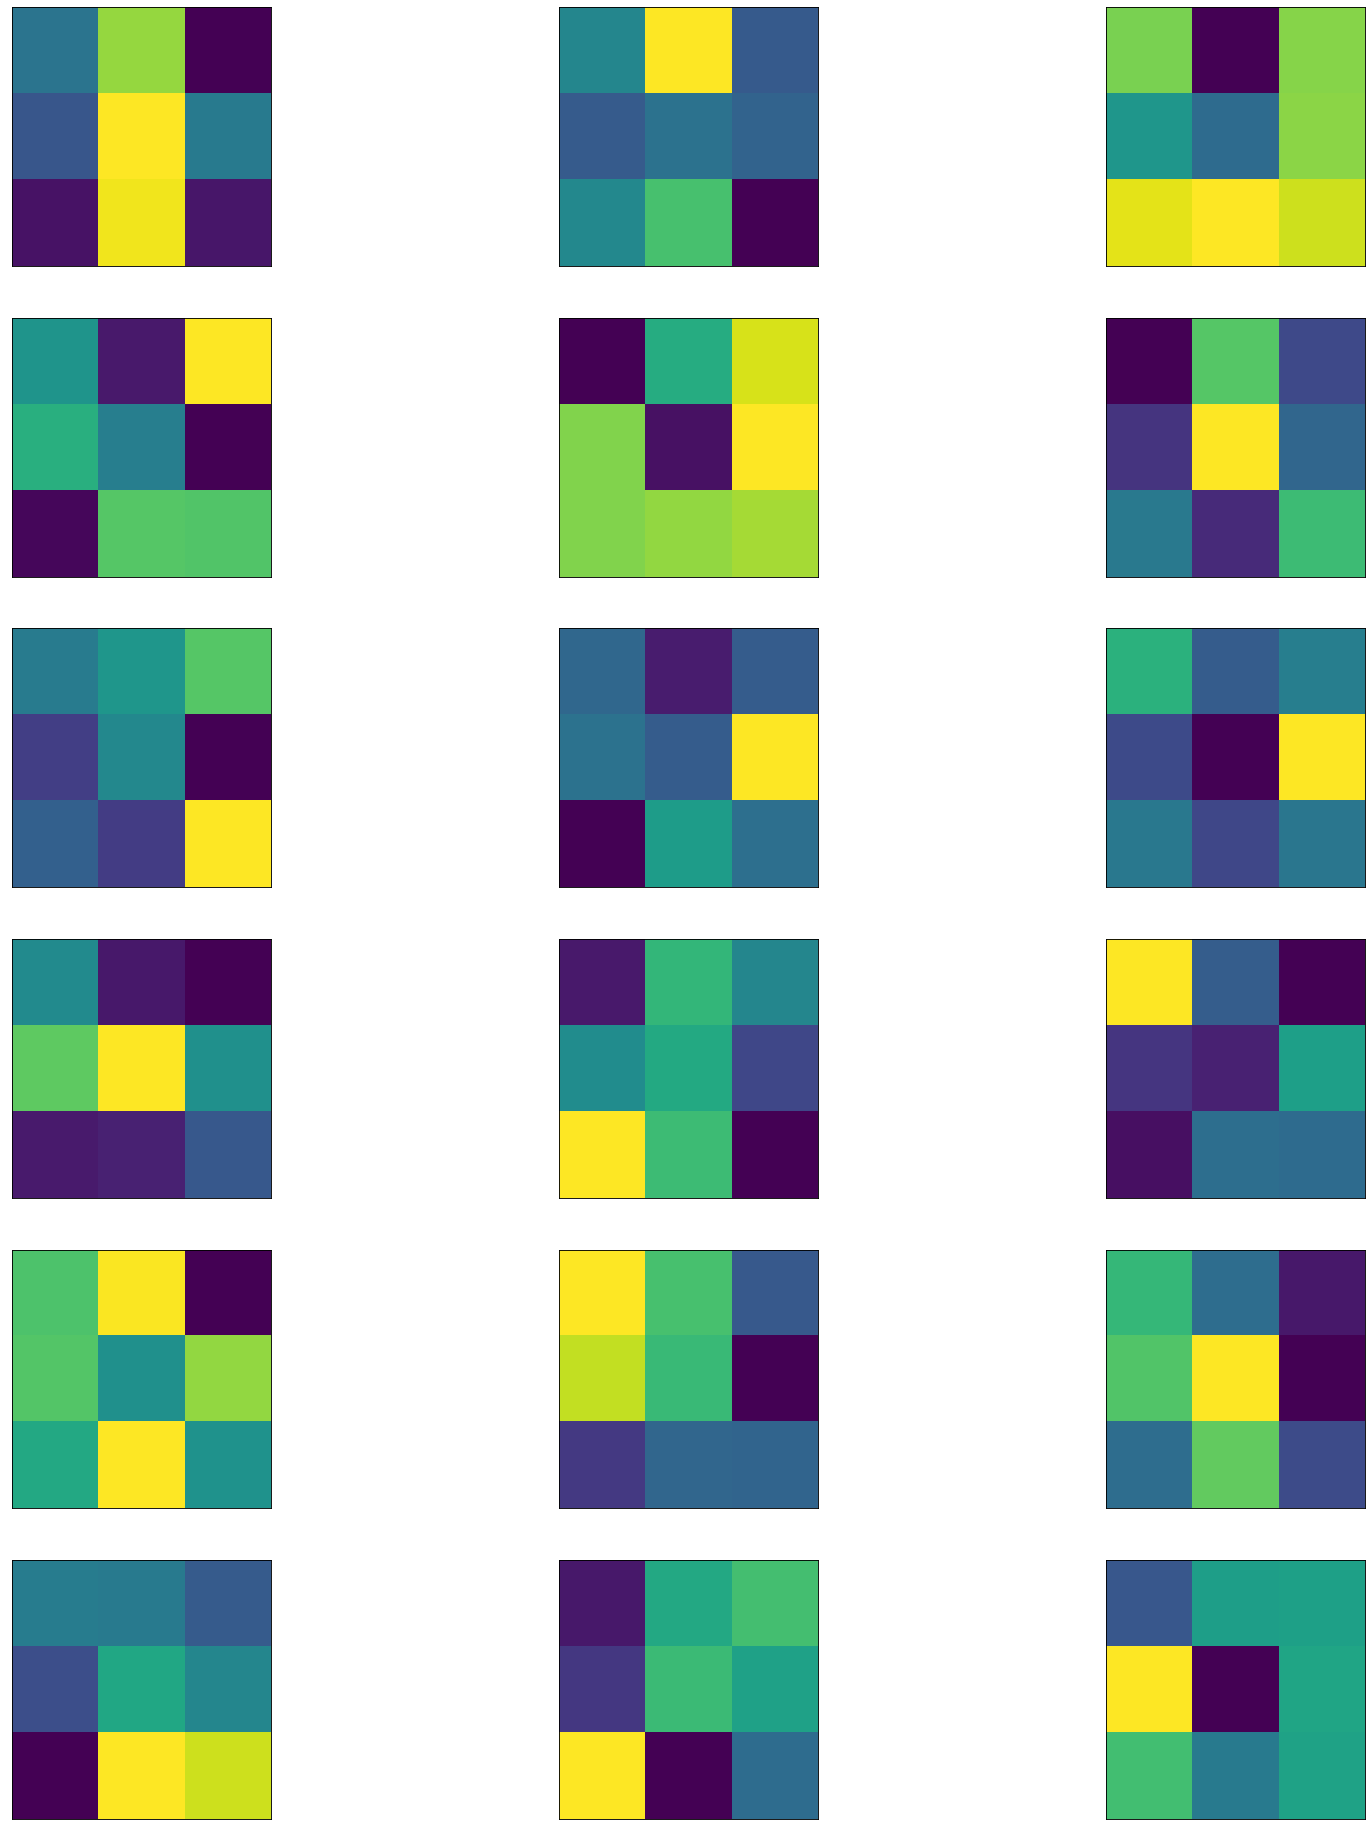

In [83]:
figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
filters, biases = model.layers[1].get_weights()

f_min, f_max = filters.min(), filters.max()
filters = (filters - f_min) / (f_max - f_min)

n_filters, ix = 6, 1
for i in range(n_filters):
	f = filters[:, :, :, i]
	for j in range(3):
		ax = pyplot.subplot(n_filters,3 , ix)
		ax.set_xticks([])
		ax.set_yticks([])
		pyplot.imshow(f[:, :, j])
		ix += 1
pyplot.show()

In [84]:

def image_transform_gray(image):
    img = expand_dims(image, axis=0)
    model1 = Model(inputs=model.inputs, outputs=model.layers[0].output)
    feature_maps = model1.predict(img)
    figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
    square = 4
    ix = 1
    for _ in range(square):
        for _ in range(square):
            
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(feature_maps[0, :, :, ix-1],cmap='gray')
            ix += 1
    pyplot.show()
def image_transform(image):
    img = expand_dims(image, axis=0)
    model1 = Model(inputs=model.inputs, outputs=model.layers[0].output)
    feature_maps = model1.predict(img)
    figure(num=None, figsize=(25, 30), dpi=80, facecolor='w', edgecolor='k')
    square = 4
    ix = 1
    for _ in range(square):
        for _ in range(square):
            ax = pyplot.subplot(square, square, ix)
            ax.set_xticks([])
            ax.set_yticks([])
            pyplot.imshow(feature_maps[0, :, :, ix-1])
            ix += 1
    pyplot.show()

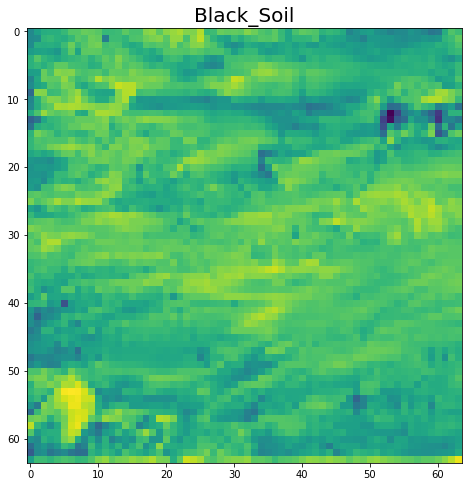

In [85]:
plt.figure(figsize=(25,8))
plt.imshow(X[66].reshape(w,h))
plt.title(enc.inverse_transform(y[0].reshape(1,final_class))[0][0],size = 20)
plt.show()

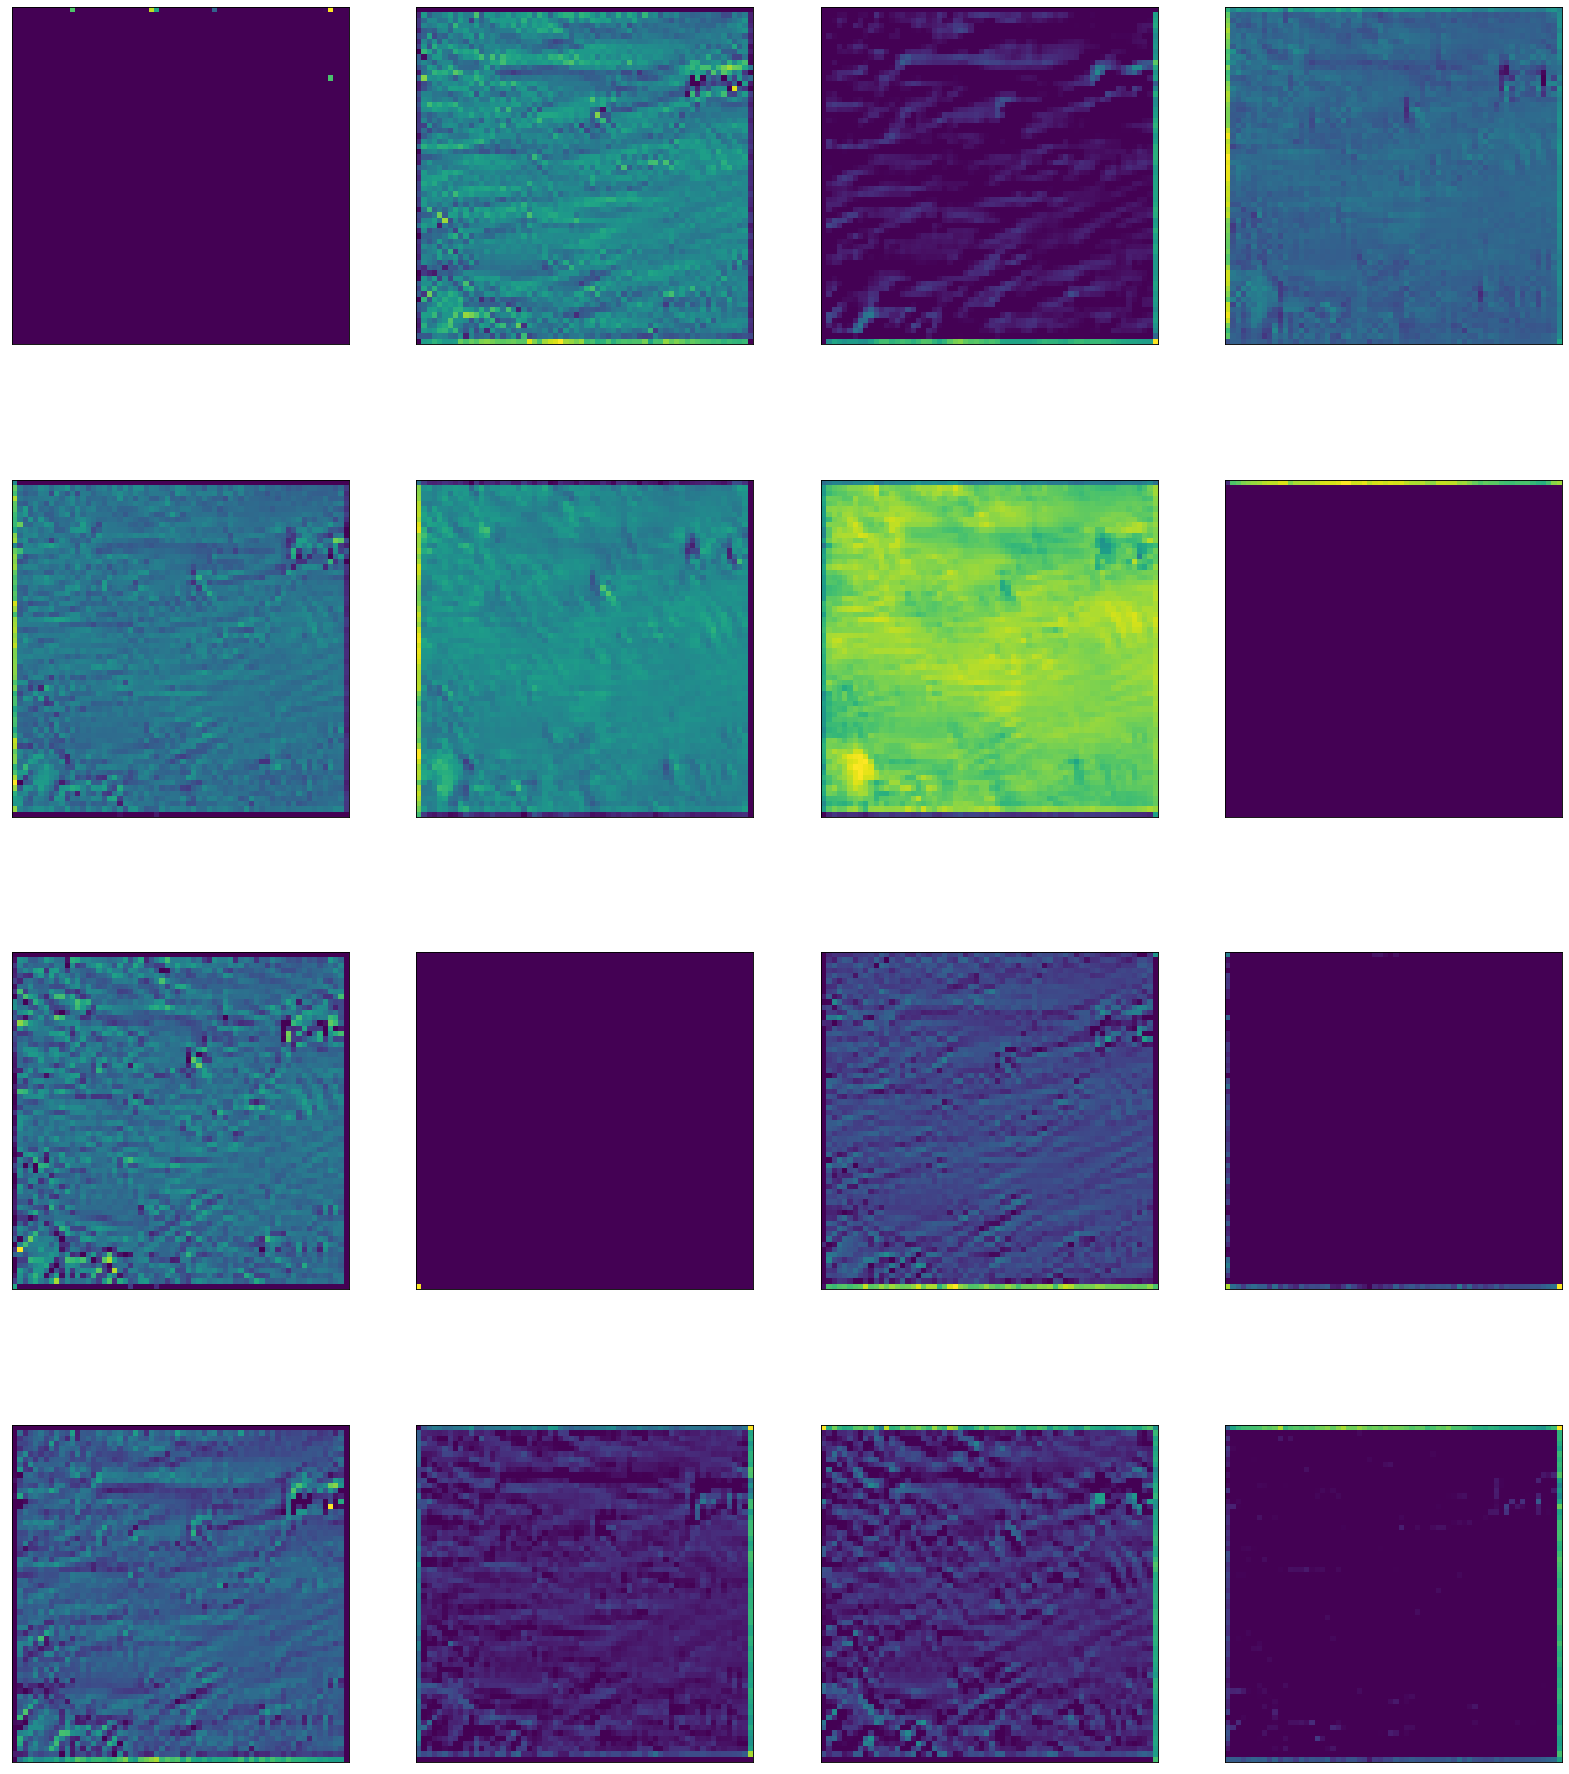

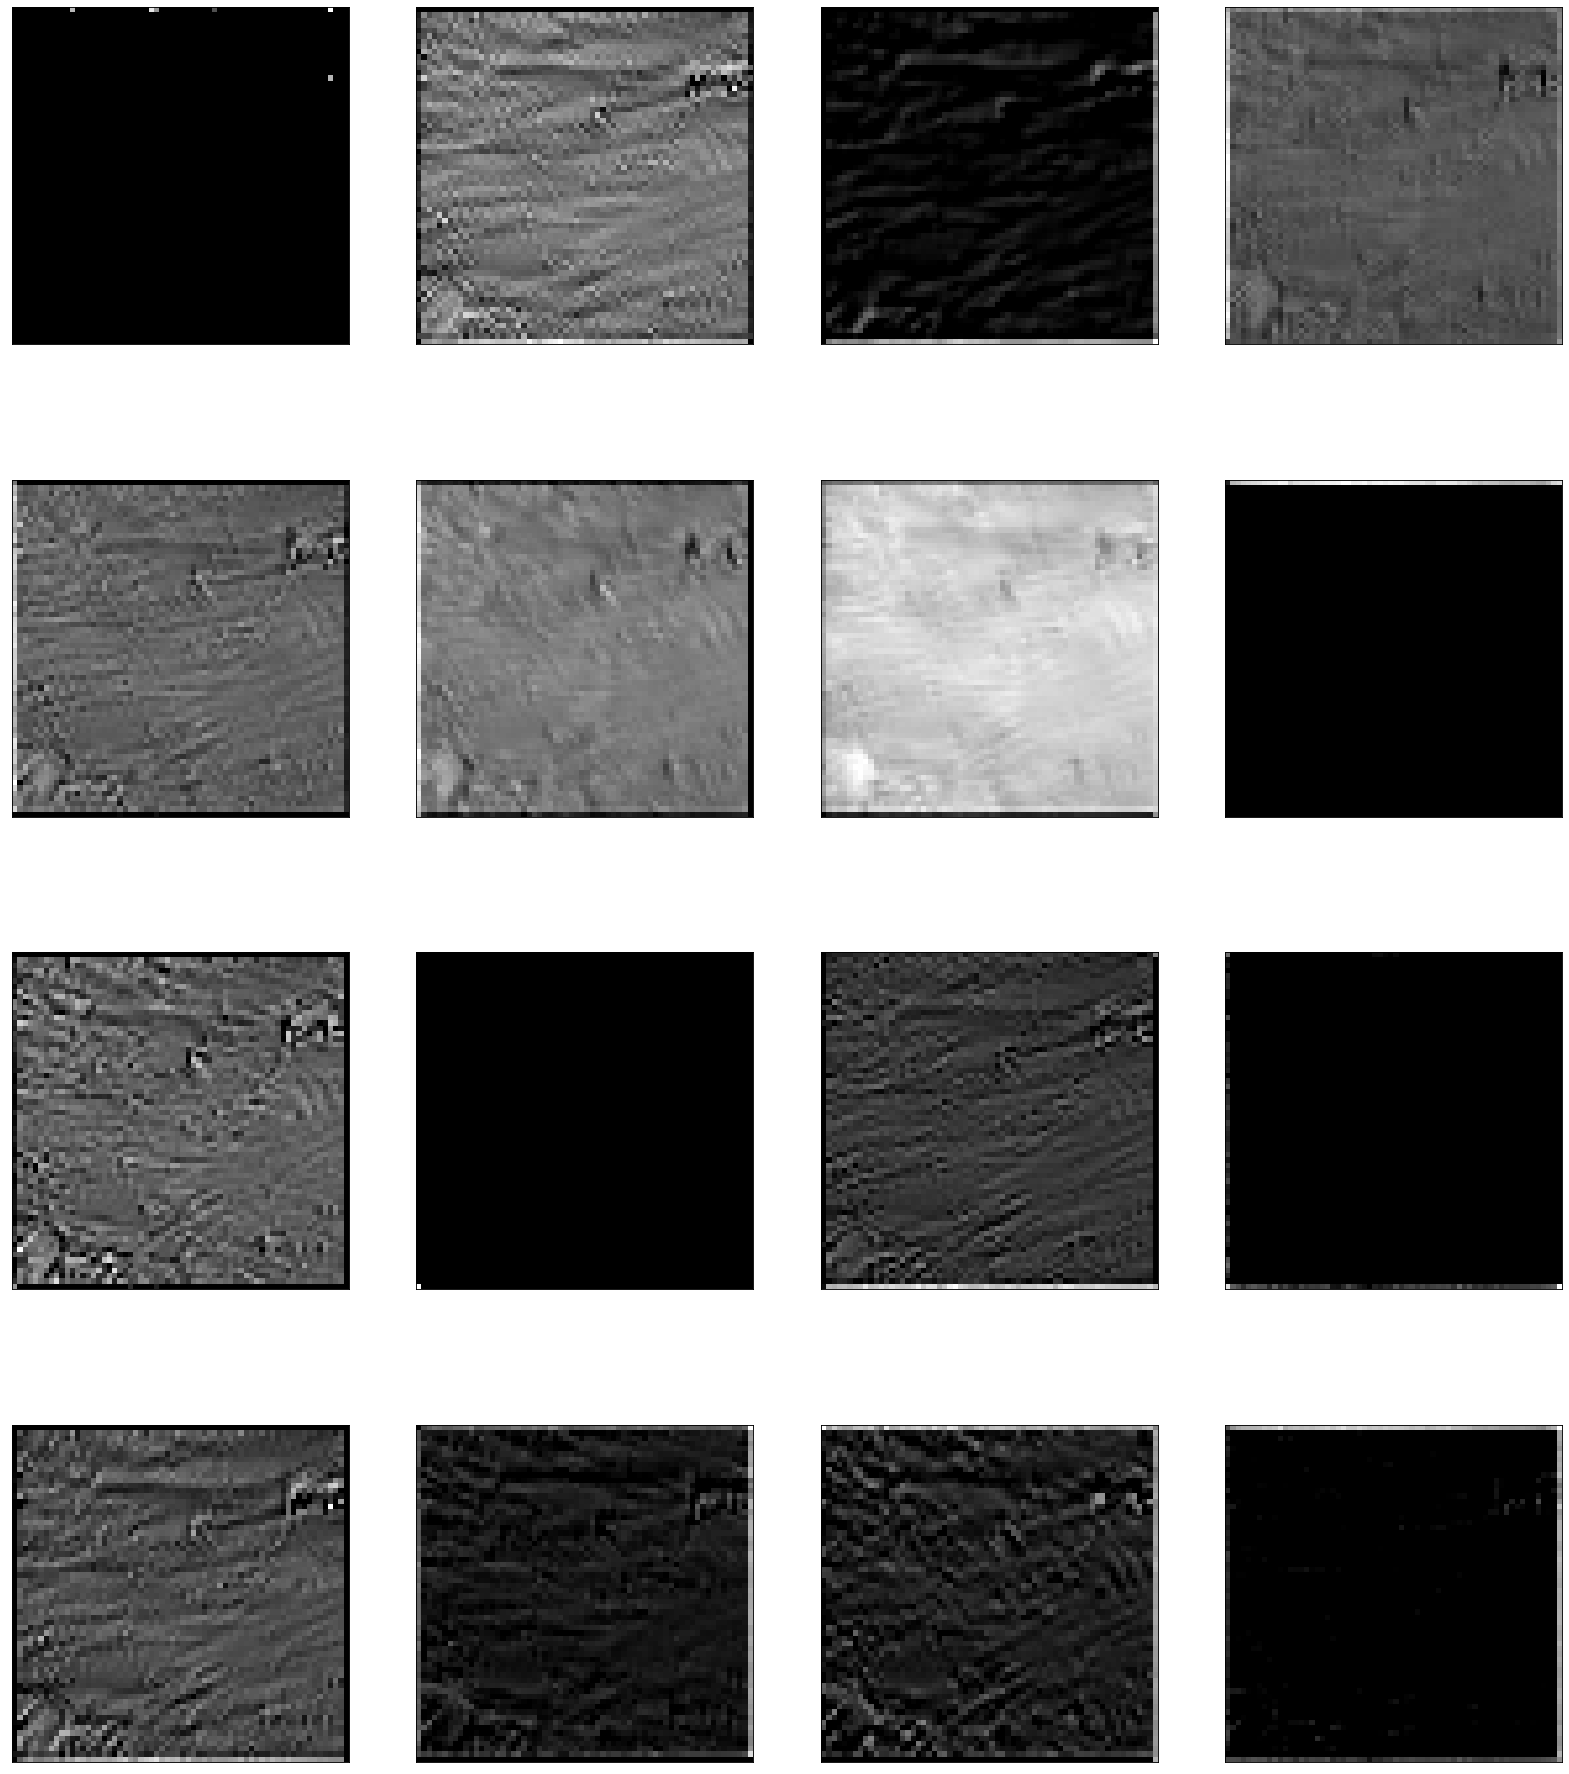

In [86]:
image_transform(X[66])
image_transform_gray(X[66])

In [87]:
y_pred = model.evaluate(X_test , y_test,verbose =1)

3/3 [==============================] - 0s 24ms/step - loss: 1.4480 - accuracy: 0.6923 - precision: 0.6957 - recall: 0.7033


In [88]:
fig = go.Figure(data=[
    go.Bar(name = 'Accuracy',x=['Training','Validation','Real World Data'], y=[history.history['accuracy'][49] ,history.history['val_accuracy'][49],y_pred[1] ]),
    go.Bar(name = 'Precision',x=['Training','Validation','Real World Data'], y=[history.history['precision'][49] ,history.history['val_precision'][49],y_pred[2] ]),
    go.Bar(name = 'Loss',x=['Training','Validation','Real World Data'], y=[history.history['loss'][49] ,history.history['val_loss'][49],y_pred[0] ]),

])
fig.update_layout(barmode='group', title_text="Training Accuracy/Precsion/Loss")
fig.update_yaxes(type = "log")
pyo.iplot(fig, filename = 'Act_train_rec')

In [89]:
X_test[0]

array([[[27],
        [30],
        [43],
        ...,
        [56],
        [57],
        [60]],

       [[31],
        [37],
        [59],
        ...,
        [51],
        [48],
        [57]],

       [[43],
        [36],
        [43],
        ...,
        [46],
        [36],
        [41]],

       ...,

       [[39],
        [59],
        [52],
        ...,
        [60],
        [46],
        [36]],

       [[31],
        [53],
        [44],
        ...,
        [43],
        [34],
        [45]],

       [[49],
        [54],
        [50],
        ...,
        [54],
        [34],
        [55]]], dtype=uint8)

In [90]:
y_prediction = model.predict(X_test)
def binary_classify(y_pred):
    for inp in y_pred:
        maximum = 0
        index = 0
        for i in range(final_class):
            if(maximum != max(maximum,inp[i])):
                maximum = max(maximum,inp[i])
                index = i
            inp[i] = 0
        inp[index]=1
    return y_pred
y_prediction  = binary_classify(y_prediction)

In [91]:
y_prediction

array([[0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],


In [92]:
def create_result(y):
    y_final = []
    for i in range(y.shape[0]):
        y_final.append(enc.inverse_transform(y[i].reshape(1,final_class))[0][0])
    return y_final 
def remove_none(y , y_pred):
    index = []
    for i in range(len(y)-1,0,-1):
        if y_pred[i] == None :
            del y[i]
            del y_pred[i]
        
    return y , y_pred
def label_encode(y , y_pred):
    le = preprocessing.LabelEncoder()
    le.fit(y_pred)
    print(le.classes_)
    y = le.transform(y)
    y_pred = le.transform(y_pred)
    return y , y_pred
valluvial=1
vblack=0
vclay=0
vred=0
y_class_result = create_result(y_prediction)
y_class_desired = create_result(y_test)

In [93]:
y_label_desired , y_label_result = label_encode(y_class_desired , y_class_result) 


['Alluvial_Soil' 'Black_Soil' 'Clay_Soil' 'Red_Soil']


In [94]:
from sklearn.metrics import classification_report
tn = []
for cat in enc.categories_[0].reshape(final_class,1):
    tn.append(cat[0])
target_names = tn
print(classification_report(y_label_desired, y_label_result, target_names=target_names))

               precision    recall  f1-score   support

Alluvial_Soil       0.45      0.86      0.59        21
   Black_Soil       0.88      1.00      0.94        22
    Clay_Soil       1.00      0.79      0.88        19
     Red_Soil       0.73      0.28      0.40        29

     accuracy                           0.69        91
    macro avg       0.76      0.73      0.70        91
 weighted avg       0.76      0.69      0.67        91



In [95]:
my_image = []
img = cv2.imread("p1/1.jpg",0)
img = cv2.resize(img, (w,h), interpolation = cv2.INTER_AREA)
img = img.reshape(w,h,1)
my_image.append(img)

In [96]:
X1 = np.array(my_image)

In [97]:
my_pred = model.predict(X1)
my_pred  = binary_classify(my_pred)

In [98]:
my_pred

array([[1., 0., 0., 0.]], dtype=float32)

In [99]:
my_pred[0][0], my_pred[0][1], my_pred[0][2], my_pred[0][3]

(1.0, 0.0, 0.0, 0.0)

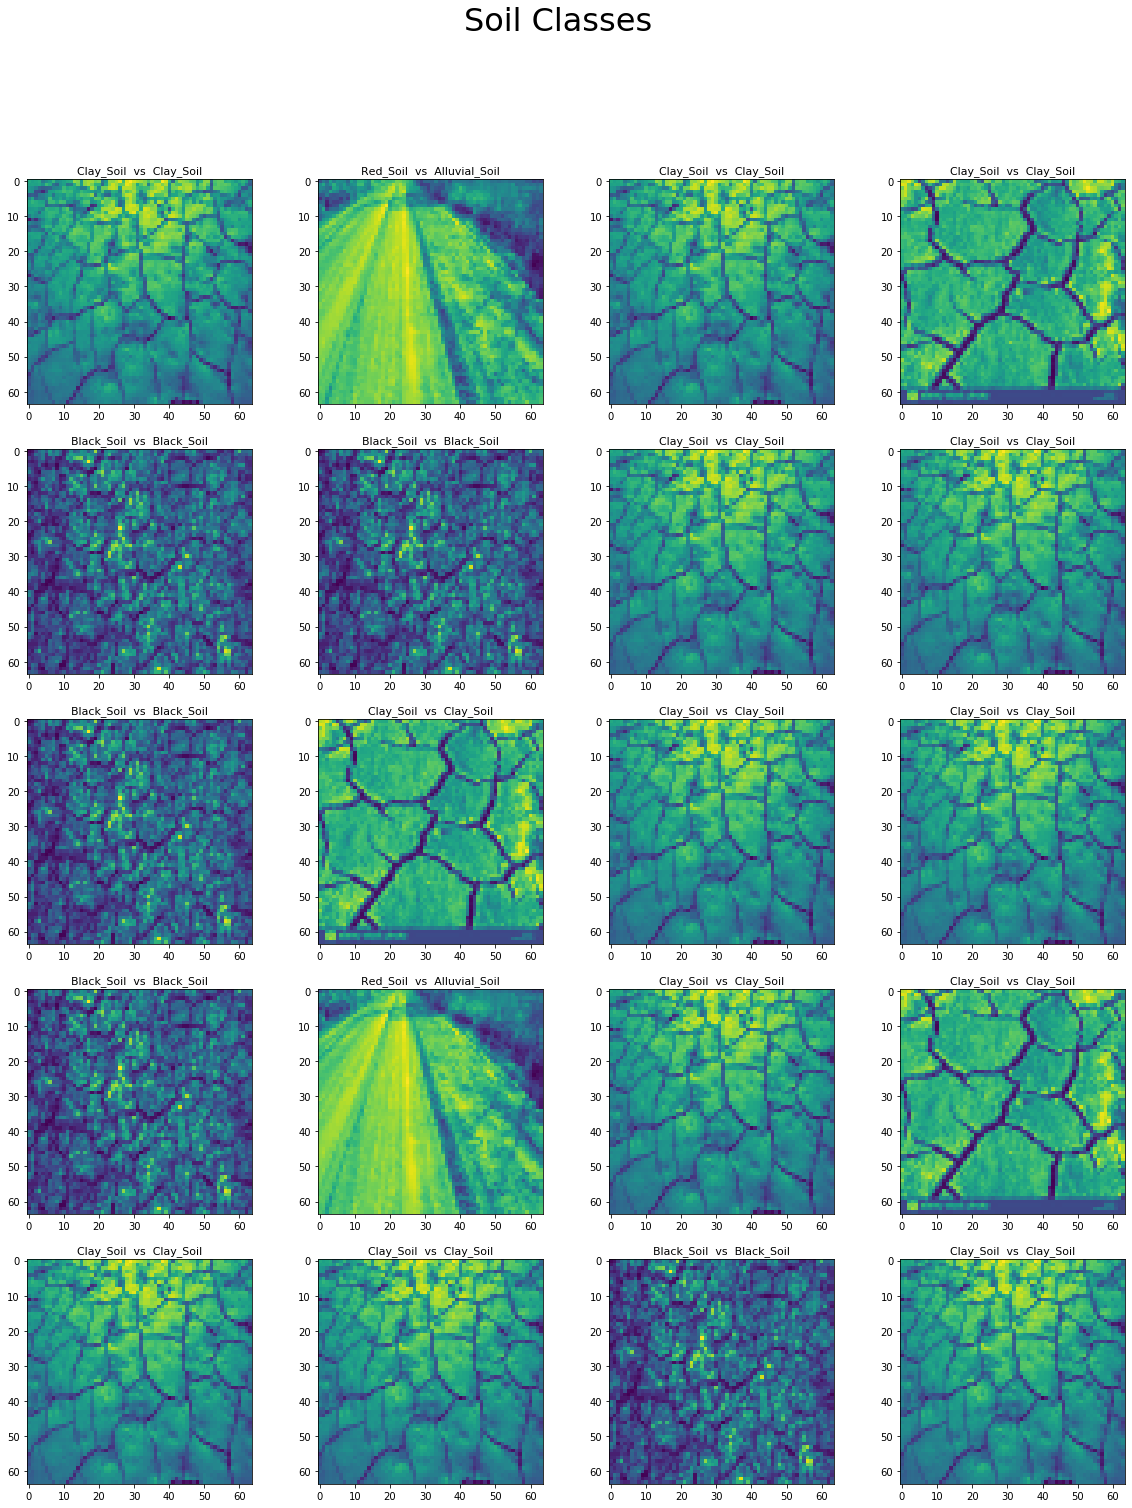

In [100]:
count = 1
f = plt.figure(figsize=(20,24))
for i in range(20):
    ind = random.sample(list(y_label_result),1)[0]
    img = X_test[ind]
    Class = str(y_class_desired[ind]) + '  vs  '+str(y_class_result[ind])
    ax = f.add_subplot(5, 4,count)
    ax = plt.imshow(img.reshape(w,h))
    ax = plt.title(Class,fontsize= 11)
    count = count + 1
plt.suptitle("Soil Classes", size = 32)
plt.show()

In [102]:
import seaborn as sns

from wordcloud import WordCloud, STOPWORDS
from PIL import Image

import plotly.graph_objs as go
import warnings
warnings.filterwarnings("ignore")

pd.options.display.max_columns = None


In [103]:
df = pd.read_csv('CropDataset1.csv')
df.head()

N   P   K  temperature   humidity        ph    rainfall  alluvial  black  \
0  90  42  43    20.879744  82.002744  6.502985  202.935536         0      1   
1  85  58  41    21.770462  80.319644  7.038096  226.655537         0      1   
2  60  55  44    23.004459  82.320763  7.840207  263.964248         0      1   
3  74  35  40    26.491096  80.158363  6.980401  242.864034         0      1   
4  78  42  42    20.130175  81.604873  7.628473  262.717340         0      1   

   clay  red label  
0     1    0  rice  
1     1    0  rice  
2     1    0  rice  
3     1    0  rice  
4     1    0  rice

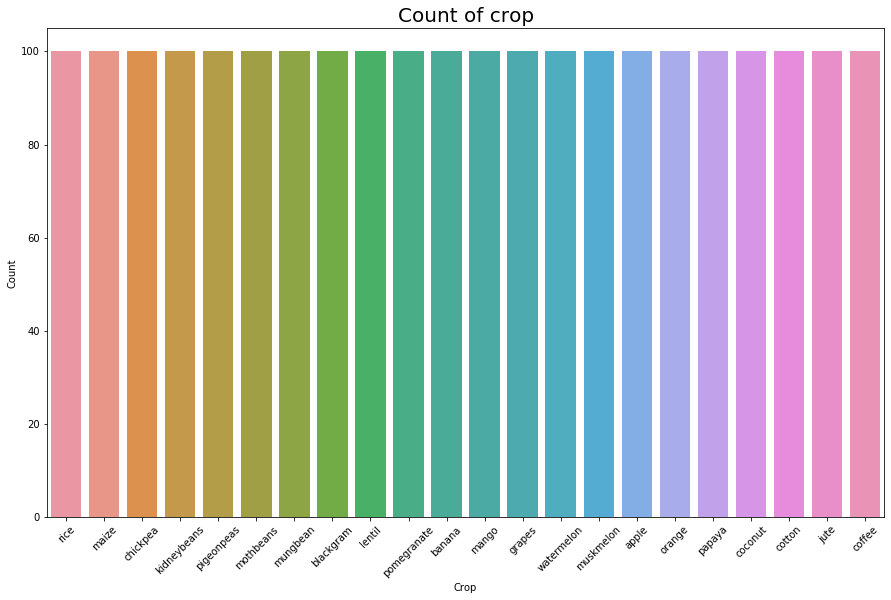

In [104]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
import seaborn as sns
sns.countplot(data=df, x='label')
ax.set(xlabel='Crop')
ax.set(ylabel='Count')
plt.xticks(rotation=45)

plt.title('Count of crop', fontsize = 20, c='black')
plt.show()

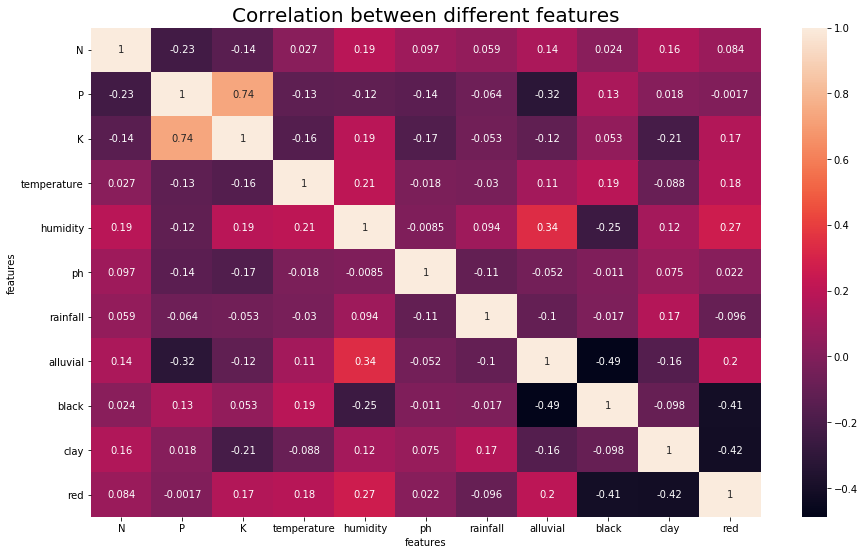

In [105]:
fig, ax = plt.subplots(1, 1, figsize=(15, 9))
sns.heatmap(df.corr(), annot=True)
ax.set(xlabel='features')
ax.set(ylabel='features')

plt.title('Correlation between different features', fontsize = 20, c='black')
plt.show()

In [106]:
from sklearn.model_selection import KFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from xgboost.sklearn import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [107]:
target = ['label']
features = ['N', 'P', 'K', 'temperature', 'humidity', 'ph', 'rainfall', 'alluvial','black','clay', 'red']

In [108]:
X = df[features]
y = df[target]

In [109]:
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=True)

In [110]:
models = []
models.append(('LogisticRegression', LogisticRegression(random_state=0)))
models.append(('DecisionTreeClassifier', DecisionTreeClassifier(random_state=0)))
models.append(('XGBClassifier', XGBClassifier(random_state=0)))
models.append(('GradientBoostingClassifier', GradientBoostingClassifier(random_state=0)))
models.append(('KNeighborsClassifier', KNeighborsClassifier()))
models.append(('RandomForestClassifier', RandomForestClassifier(random_state=0)))

In [111]:
model_name = []
accuracy = []

In [112]:
for name, model in models: 
    model.fit(X_train1,y_train1)
    y_pred1=model.predict(X_test1)
    model_name.append(name)
    accuracy.append(metrics.accuracy_score(y_test1,y_pred1))
    print(name, metrics.accuracy_score(y_test1,y_pred1))

LogisticRegression 0.9600550964187328
DecisionTreeClassifier 1.0
[15:01:52] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier 0.9958677685950413
GradientBoostingClassifier 0.9986225895316805
KNeighborsClassifier 0.9765840220385675
RandomForestClassifier 1.0


In [113]:
model.fit(X_train1,y_train1)
y_pre1d=model.predict(X_test1)

In [114]:
from sklearn import metrics

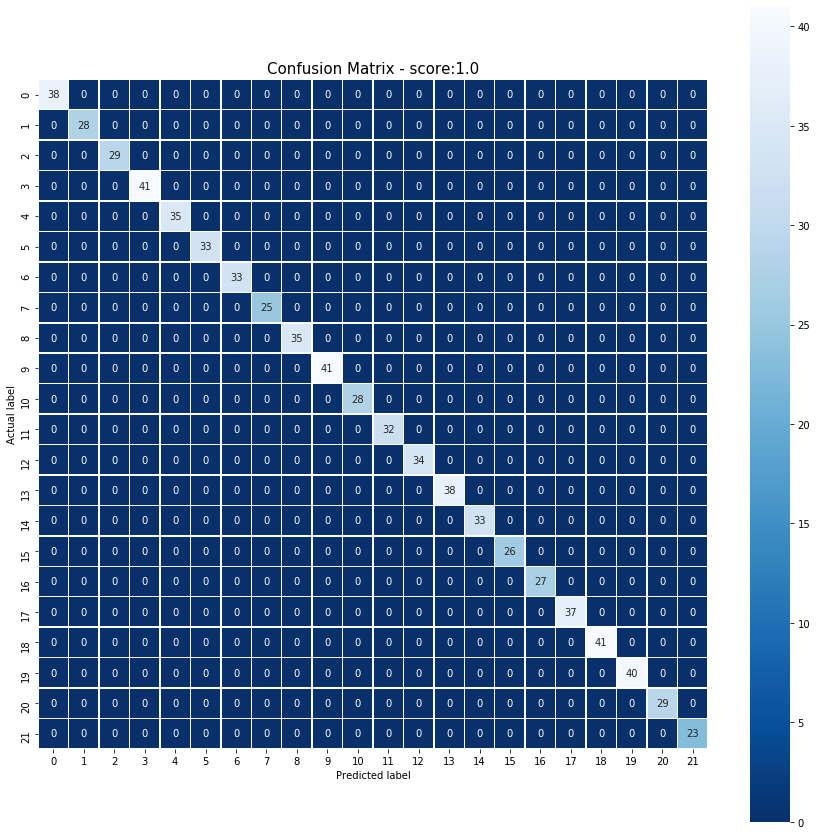

              precision    recall  f1-score   support

       apple       1.00      1.00      1.00        38
      banana       1.00      1.00      1.00        28
   blackgram       1.00      1.00      1.00        29
    chickpea       1.00      1.00      1.00        41
     coconut       1.00      1.00      1.00        35
      coffee       1.00      1.00      1.00        33
      cotton       1.00      1.00      1.00        33
      grapes       1.00      1.00      1.00        25
        jute       1.00      1.00      1.00        35
 kidneybeans       1.00      1.00      1.00        41
      lentil       1.00      1.00      1.00        28
       maize       1.00      1.00      1.00        32
       mango       1.00      1.00      1.00        34
   mothbeans       1.00      1.00      1.00        38
    mungbean       1.00      1.00      1.00        33
   muskmelon       1.00      1.00      1.00        26
      orange       1.00      1.00      1.00        27
      papaya       1.00    

In [115]:
cm = metrics.confusion_matrix(y_test1, y_pred1)
plt.figure(figsize=(15,15))
sns.heatmap(cm, annot=True, fmt=".0f", linewidths=.5, square = True, cmap = 'Blues_r');
plt.ylabel('Actual label');
plt.xlabel('Predicted label');
all_sample_title = 'Confusion Matrix - score:'+str(metrics.accuracy_score(y_test1,y_pred1))
plt.title(all_sample_title, size = 15);
plt.show()
print(metrics.classification_report(y_test1,y_pred1))

In [116]:
from IPython.core.display import HTML, display

In [117]:
HTML("<h1 style='color:green;text-decoration:underline;text-align:center;margin:35pt;'>Suggestion to Our Farmer</h1>")

In [118]:
import ipywidgets as widgets

In [119]:
from ipywidgets import interact

In [120]:
layout = widgets.Layout(width='auto')

In [121]:
nr = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Nitrogen Ratio Content in Soil:',
    style={'description_width': 'initial', 'width': '200px'}, 
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout = layout
)

In [122]:
pr = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Phosphorous Ratio Content in Soil:',
    style={'description_width': 'initial', 'width': '200px'}, 
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout = layout
)

In [123]:
kr = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Potassium Ratio Content in Soil:',
     style={'description_width': 'initial', 'width': '200px'}, 
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout = layout
)

In [124]:
temperature = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Temperature in degree Celsius:',
    style={'description_width': 'initial', 'width': '200px'}, 
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout = layout
)

In [125]:
humidity = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Relative Humidity in % :',
    style={'description_width': 'initial', 'width': '200px'}, 
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout = layout
)

In [126]:
ph = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description='pH Value of Soil :',
    style={'description_width': 'initial', 'width': '200px'}, 
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout = layout
)

In [127]:
rainfall = widgets.IntSlider(
    value=0,
    min=0,
    max=100,
    step=1,
    description='Rainfall in mm :',
    style={'description_width': 'initial', 'width': '200px'}, 
    disabled=False,
    continuous_update=False,
    orientation='horizontal',
    readout=True,
    readout_format='d',
    layout = layout
)

In [128]:
nr_value = 0
def nr_data(ctrl):
    global nr_value
    nr_value = ctrl

In [129]:
pr_value = 0
def pr_data(ctrl):
    global pr_value
    pr_value = ctrl

In [130]:
kr_value = 0
def kr_data(ctrl):
    global kr_value
    kr_value = ctrl

In [131]:
temp_value = 0
def temp_data(ctrl):
    global temp_value
    temp_value = ctrl

In [132]:
hum_value = 0
def hum_data(ctrl):
    global hum_value
    hum_value = ctrl

In [133]:
ph_value = 0
def ph_data(ctrl):
    global ph_value
    ph_value = ctrl

In [134]:
rain_value = 0
def rain_data(ctrl):
    global rain_value
    rain_value = ctrl

In [135]:
interact(nr_data, ctrl=nr)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Nitrogen Ratio Content in Soil:…

<function __main__.nr_data(ctrl)>

In [136]:
interact(pr_data, ctrl=pr)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Phosphorous Ratio Content in So…

<function __main__.pr_data(ctrl)>

In [137]:
interact(kr_data, ctrl=kr)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Potassium Ratio Content in Soil…

<function __main__.kr_data(ctrl)>

In [138]:
interact(temp_data, ctrl=temperature)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Temperature in degree Celsius:'…

<function __main__.temp_data(ctrl)>

In [139]:
interact(hum_data, ctrl=humidity)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Relative Humidity in % :', layo…

<function __main__.hum_data(ctrl)>

In [140]:
interact(ph_data, ctrl=ph)

interactive(children=(IntSlider(value=0, continuous_update=False, description='pH Value of Soil :', layout=Lay…

<function __main__.ph_data(ctrl)>

In [141]:
interact(rain_data, ctrl=rainfall)

interactive(children=(IntSlider(value=0, continuous_update=False, description='Rainfall in mm :', layout=Layou…

<function __main__.rain_data(ctrl)>

In [142]:
sample = [nr_value, pr_value, kr_value, temp_value, hum_value, ph_value, rain_value, my_pred[0][0], my_pred[0][1], my_pred[0][2], my_pred[0][3]]
single_sample = np.array(sample).reshape(1,-1)
pred = model.predict(single_sample)


In [143]:
HTML("<h1 style='color:green;text-decoration:underline;text-align:center;margin:35pt;'>Suggested Crop is "+pred.item().title()+"</h1>")